In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 入力ファイルの皆さん
TRAINS = [
    "../hdf/train_categorical.hdf",
    "../hdf/train_numeric.hdf",
#     "../hdf/train_date_L0_normalized.hdf",
    "../hdf/train_date_L1_normalized.hdf",
    "../hdf/train_date_L2_normalized.hdf",
    "../hdf/train_date_L3_normalized.hdf",
    "../hdf/train_date_min_max.hdf",
    "../hdf/train_date_L0_min_max.hdf",
    "../hdf/train_date_L1_min_max.hdf",
    "../hdf/train_date_L2_min_max.hdf",
    "../hdf/train_date_L3_min_max.hdf",
    "../hdf/train_categorical_L3_S32_F3854_decomposite.hdf",
    "../hdf/train_numeric_L1_S24_F1844_extract.hdf",
    "../hdf/train_numeric_L1_S24_F1723_-0.12.hdf",
    "../hdf/train_numeric_L1_S24_F1723_extract.hdf",
    "../hdf/train_S24_C_md5.hdf"
]
TESTS = []
for file in TRAINS:
    TESTS.append(file.replace("train", "test"))
RESPONSE = "../hdf/train_response.hdf"

index を分割する

In [13]:
def split_indices(train_df, test_df):
    md5_sum_S24_C_md5 = train_df.loc[[137]]["S24_C_md5"].values[0]
    train_index_list = []
    test_index_list = []
    train = train_df[train_df["S24_C_md5"] == md5_sum_S24_C_md5].index
    train_index_list.append(train)
    train_df.drop(train, inplace=True)
    train_index_list.append(train_df.index)
    test = test_df[test_df["S24_C_md5"] == md5_sum_S24_C_md5].index
    test_index_list.append(test)
    test_df.drop(test, inplace=True)
    test_index_list.append(test_df.index)
    return train_index_list, test_index_list

In [4]:
def xgboost_bosch(train_indices):
    print("Loading Train Data...")
    X = pd.concat(
        (pd.read_hdf(filename).loc[train_indices] for filename in TRAINS),
        axis=1)
    columns = X.columns
    if len(X.index) > 1000000:
        print("Train Data is too large! size={s}".format(s=len(X.index)))
        X = X.sample(frac=0.8)
    y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()
    X = X.values
    # Feature Selection
    print("Selecting Train Features...")
    clf = XGBClassifier(base_score=0.005)
    clf.fit(X, y)
    important_indices = np.where(clf.feature_importances_ > 0.005)[0]
    important_columns = [columns[i] for i in important_indices]
    print(important_columns)
    # Reload Train Data
    print("Reloading Train Data...")
    X = pd.concat(
        (drop_columns(
            pd.read_hdf(filename).loc[train_indices], important_columns)
         for filename in TRAINS),
        axis=1)
    y = pd.read_hdf(RESPONSE)
    y = y.loc[X.index].values.ravel()
    X = X.values
    # 予測して Cross Validation
    print("Predicting...")
    clf = XGBClassifier(max_depth=6, base_score=0.005)
    cv = StratifiedKFold(y, n_folds=3)
    predictions = np.ones(y.shape[0])
    for i, (train, test) in enumerate(cv):
        predictions[test] = clf.fit(X[train],
                                    y[train]).predict_proba(X[test])[:, 1]
        print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[
            test], predictions[test])))
    print(roc_auc_score(y, predictions))
    # MCC 最適化
    thresholds = np.linspace(0.01, 0.99, 200)
    mcc = np.array(
        [matthews_corrcoef(y, predictions > thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print(mcc.max())
    return important_columns, clf, best_threshold

def drop_columns(df, undrop_columns):
    drop_columns = [c for c in df.columns if c not in undrop_columns]
    df.drop(drop_columns, axis=1, inplace=True)
    return df

def predict(important_columns, test_indices, clf, best_threshold):
    # テストデータ読み込み
    print("Loading Test Data...")
    X = pd.concat(
        (drop_columns(
            pd.read_hdf(filename).loc[test_indices], important_columns)
         for filename in TESTS),
        axis=1)
    X = X.values
    # 0 or 1 に正規化
    predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)
    # 提出データを生成
    sub = pd.DataFrame(index=test_indices.astype(np.int32), columns=[])
    sub["Response"] = predictions
    return sub

In [14]:
train_df = pd.read_hdf("../hdf/train_S24_C_md5.hdf")
test_df = pd.read_hdf("../hdf/test_S24_C_md5.hdf")

In [15]:
train_index_list, test_index_list = split_indices(train_df, test_df)

Loading Train Data...
Train Data is too large! size=1124038
Selecting Train Features...
['L3_S32_F3854', 'L0_S0_F20', 'L0_S2_F44', 'L0_S3_F72', 'L0_S4_F104', 'L0_S4_F109', 'L0_S10_F259', 'L0_S16_F426', 'L1_S24_F867', 'L1_S24_F1102', 'L1_S24_F1494', 'L1_S24_F1498', 'L1_S24_F1575', 'L1_S24_F1723', 'L1_S24_F1846', 'L2_S26_F3073', 'L2_S26_F3106', 'L2_S27_F3166', 'L3_S29_F3339', 'L3_S29_F3351', 'L3_S29_F3376', 'L3_S29_F3407', 'L3_S29_F3479', 'L3_S30_F3534', 'L3_S30_F3544', 'L3_S30_F3704', 'L3_S30_F3744', 'L3_S30_F3754', 'L3_S30_F3759', 'L3_S30_F3769', 'L3_S30_F3774', 'L3_S30_F3804', 'L3_S30_F3809', 'L3_S30_F3829', 'L3_S33_F3857', 'L3_S35_F3896', 'L3_S38_F3952', 'L3_S38_F3960', 'L3_S33_D3856_normalized', 'L3_S38_D3953_normalized', 'min', 'max', 'min_max', 'L0_min', 'L0_max', 'L1_max', 'L2_min', 'L3_min', 'L3_max', 'L3_min_max', 'L3_S32_F3854_48']
Reloading Train Data...
Predicting...
fold 0, ROC AUC: 0.721
fold 1, ROC AUC: 0.711
fold 2, ROC AUC: 0.699
0.710073088944


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.235517377983
Loading Test Data...


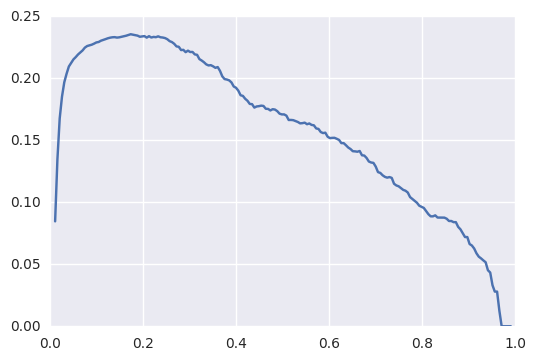

In [7]:
important_columns, clf, best_threshold = xgboost_bosch(train_index_list[1])
sub1 = predict(important_columns, test_index_list[1], clf, best_threshold)

Loading Train Data...
Selecting Train Features...
['L3_S32_F3854', 'L1_S24_F1514', 'L1_S24_F1516', 'L1_S24_F1518', 'L1_S24_F1520', 'L1_S24_F1565', 'L1_S24_F1571', 'L1_S24_F1575', 'L1_S24_F1578', 'L1_S24_F1581', 'L1_S24_F1599', 'L1_S24_F1604', 'L1_S24_F1632', 'L1_S24_F1637', 'L1_S24_F1657', 'L1_S24_F1667', 'L1_S24_F1778', 'L1_S24_F1798', 'L1_S24_F1808', 'L1_S24_F1812', 'L1_S24_F1829', 'L1_S24_F1831', 'L1_S24_F1842', 'L1_S24_F1844', 'L1_S24_F1846', 'L1_S24_F1850', 'L2_S26_F3051', 'L2_S26_F3069', 'L2_S26_F3073', 'L2_S26_F3106', 'L2_S26_F3113', 'L2_S26_F3117', 'L2_S26_F3121', 'L2_S27_F3162', 'L2_S27_F3199', 'L2_S27_F3206', 'L3_S29_F3324', 'L3_S29_F3333', 'L3_S29_F3339', 'L3_S29_F3345', 'L3_S29_F3348', 'L3_S29_F3351', 'L3_S29_F3354', 'L3_S29_F3376', 'L3_S29_F3379', 'L3_S30_F3534', 'L3_S30_F3604', 'L3_S30_F3629', 'L3_S30_F3674', 'L3_S30_F3709', 'L3_S30_F3749', 'L3_S30_F3774', 'L3_S30_F3804', 'L3_S30_F3809', 'L3_S32_F3850', 'L3_S33_F3857', 'L3_S33_F3859', 'L3_S33_F3865', 'L3_S35_F3896', 'L3_S

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.443254137042
Loading Test Data...


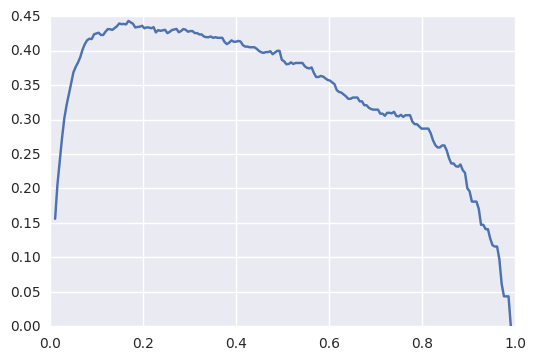

In [8]:
important_columns, clf, best_threshold = xgboost_bosch(train_index_list[0])
sub0 = predict(important_columns, test_index_list[0], clf, best_threshold)